Andrea Giampietro, 5208458

<h1><b>Analisi del sound processing e del funzionamento di un sintetizzatore</b></h1>
<img src="https://drive.google.com/uc?export=view&id=1UMCvWHllt2bn_LcHbovyqoZhEgNPuzbt" style="width:50%">

<h1><b>Obiettivi del progetto</b></h1>
<ul>
    <li>Studio della sintesi del suono</li>
    <li>Provare a ricreare un sintetizzatore ed effetti di base per analizzarli</li>
    <li>Confrontare il tutto con gli strumenti utilizzati sul campo</h2>
</ul>

<h1><b>Metodi</b></h1>
<ul>
<li><i>Signal</i> da numpy per generare forme d'onda differenti
<li>Trasformate di <i>Fourier</i>, <i>find_peaks</i> di signal e <i>hz_to_note</i> di librosa per visualizzare i picchi e le note ad essi associati
<li>Ableton Live 11, effettistica inclusa e un emulatore di sintetizzatore Arturia

In [1]:
import numpy as np
import scipy
from scipy import signal
import pandas as pd
import matplotlib.pyplot as plt
import IPython
%matplotlib inline

sample_rate = 44100
duration = 0.25
t = np.linspace(0, duration, int(sample_rate * duration))

<h1><b>Esperimenti</b></h1>
<h2><b>Come viene generato un suono?</b></h2>

<h4>Un sintetizzatore può produrre suoni fondamentali o "onde" di base. Le onde più comuni includono:</h4>
    <ul>
    <li>Onde sinusoidali: Sono onde puramente tonali e prive di armonici.
    <li>Onde quadrate: Caratterizzate da un suono ricco di armonici pari.
    <li>Onde a sega: Hanno una serie di armonici in crescita o decrescita.
    <li>Onde triangolari: Simili alle onde a sega, ma con meno armonici.
    </ul>

<h3><b>Ricreiamo un semplice sintetizzatore</b></h3>

Con l'aiuto di scipy, nello specifico di signal, sono riuscito ad ottenere una funzione che genera forme d'onda differenti in base ai parametri di input

In [2]:
def synth(form, note, duration):
    x = np.linspace(0, duration, sample_rate * duration)
    if form == 'square':
        y = signal.square(2 * np.pi * note * x)
    elif form == 'sine':
        y = np.sin(2 * np.pi * note * x)
    elif form == 'sawtooth':
        y = signal.sawtooth(2 * np.pi * note * x)
    elif form == 'triangle':
        y = np.abs(signal.sawtooth(2 * np.pi * note * x * 0.5))
    return y

audio_sq = synth('square', 440, 1) #A
IPython.display.Audio(audio_sq, rate=sample_rate)

<h3><b>Analisi delle possibili forme d'onda</b></h3>

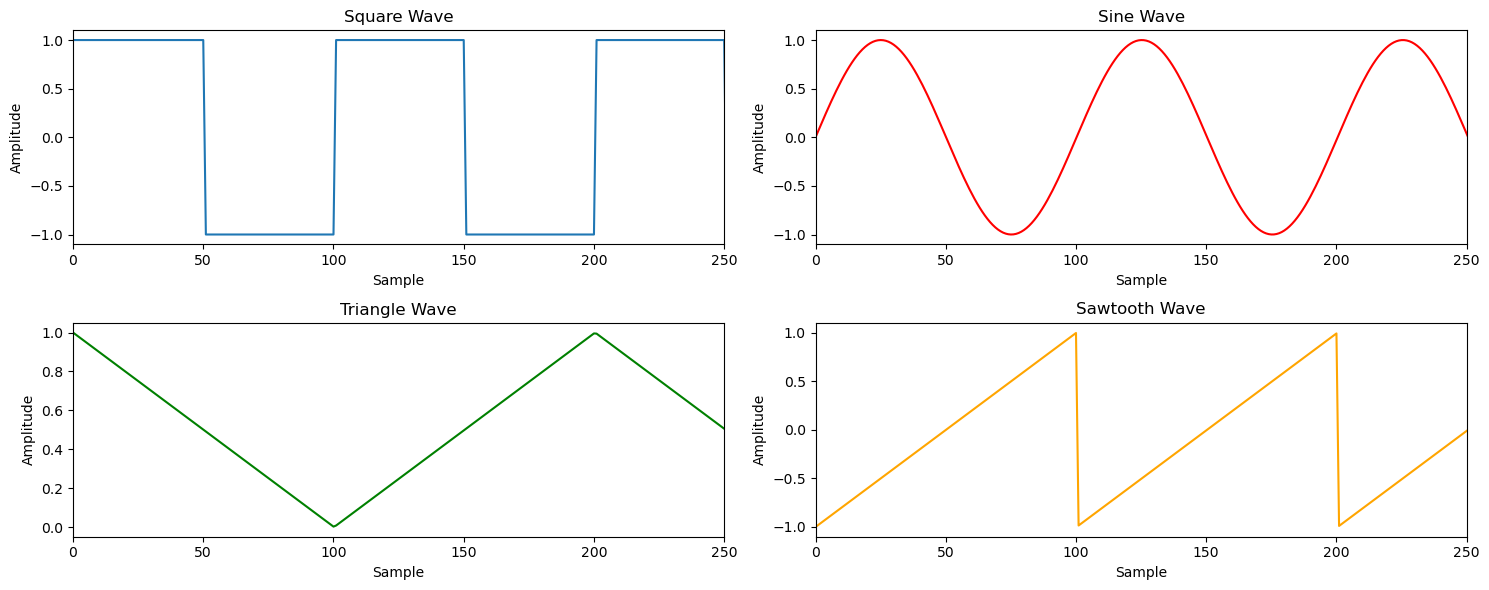

In [3]:
fig, ((pl1, pl2), (pl3, pl4)) = plt.subplots(2, 2, figsize=(15, 6))

pl1.plot(audio_sq)
pl1.set_xlim(0, 250)
pl1.set_xlabel('Sample')
pl1.set_ylabel('Amplitude')
pl1.set_title('Square Wave')

#Generiamo anche un segnale sinusoidale
audio_sin = synth('sine', 440, 1) #A

pl2.plot(audio_sin, color='red')
pl2.set_xlim(0, 250)
pl2.set_xlabel('Sample')
pl2.set_ylabel('Amplitude')
pl2.set_title('Sine Wave')

#Generiamo anche un segnale triangolare
audio_tri = synth('triangle', 440, 1) #A

pl3.plot(audio_tri, color='green')
pl3.set_xlim(0, 250)
pl3.set_xlabel('Sample')
pl3.set_ylabel('Amplitude')
pl3.set_title('Triangle Wave')

#Generiamo anche un segnale a dente di sega
audio_saw = synth('sawtooth', 440, 1) #A

pl4.plot(audio_saw, color='orange')
pl4.set_xlim(0, 250)
pl4.set_xlabel('Sample')
pl4.set_ylabel('Amplitude')
pl4.set_title('Sawtooth Wave')

fig.tight_layout()


<h3><b>Come facciamo ad avere la nota che vogliamo?</b></h3>
E' più semplice di quanto sembra, visto che quelle che noi chiamiamo note non sono altro che frequenze differenti
<br>
<br>
<img src = 'https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fi.pinimg.com%2F736x%2Fbd%2F11%2Fc6%2Fbd11c6401ab88b29a5ab2f019e4bb9b6.jpg&f=1&nofb=1&ipt=4f56bf5380208be581b110492ad53082f1bdb495a77533eea2f2f646044ced79&ipo=images'>

In [4]:
chord_notes = [440, 554.37, 659.26]  # A, C#, E
chord_duration = 2  #durata in secondi

chord_audio = np.zeros(sample_rate * chord_duration)
for note in chord_notes:
    chord_audio += synth('square', note, chord_duration)

#Aggiungiamo un sub-bass
chord_audio += synth('sine', 110, chord_duration)
#Aggiungiamo un alto sawtooth
chord_audio += synth('sawtooth', 880, chord_duration)
IPython.display.Audio(chord_audio, rate=sample_rate)

<h2><b>Fondamenti di sound processing</b></h2>

Prima di poter processare il suono dobbiamo capire "dove siamo" nello spettro delle frequenze

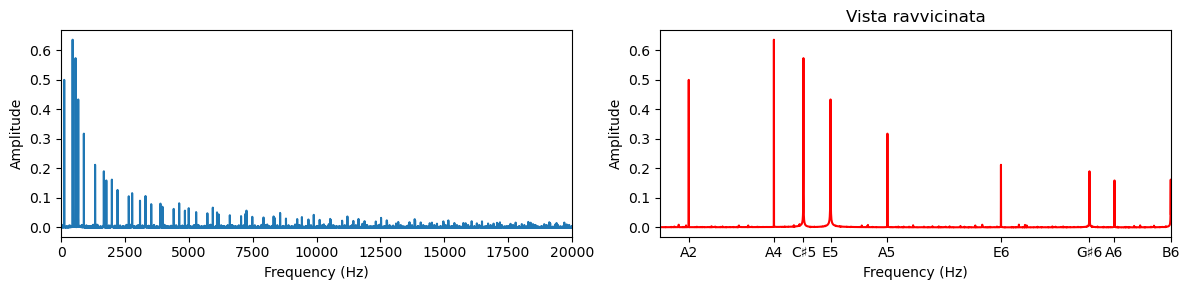

In [5]:
from scipy.signal import find_peaks
import librosa

# Applichiamo una trasformata di Fourier
chord_freq = np.fft.fftfreq(len(chord_audio), 1/sample_rate)
chord_audio_transf = np.fft.fft(chord_audio/len(chord_audio))
chord_audio_transf = np.fft.fftshift(chord_audio_transf)
chord_freq = np.fft.fftshift(chord_freq)
N = len(chord_audio)
f  = sample_rate/N * np.arange(N)

fig, (pl1, pl2) = plt.subplots(1, 2, figsize=(12, 3))

pl1.plot(chord_freq, np.abs(chord_audio_transf))
pl1.set_xlim(0, 20000)
pl1.set_xlabel('Frequency (Hz)')
pl1.set_ylabel('Amplitude')

#vediamolo più da vicino

#Troviamo i picchi
peaks, _ = find_peaks(np.abs(chord_audio_transf), height=0.15)
#Tengo solo i picchi positivi
peaks = peaks[chord_freq[peaks] > 0]

pl2.plot(chord_freq, np.abs(chord_audio_transf), color='red')

pl2.set_title('Vista ravvicinata')
pl2.set_xlim(0, 1000)
pl2.set_xlabel('Frequency (Hz)')
pl2.set_ylabel('Amplitude')
pl2.set_xticks(chord_freq[peaks], labels=librosa.hz_to_note(chord_freq[peaks]))

fig.tight_layout()
plt.show()


Grazie alla funzione hz_to_note() di librosa, possiamo osservare come i picchi corrispondando alle frequenze relative alle note dell'accordo.
Notiamo inoltre come il segnale non sia in realtà composto da solo le tre note "suonate", ma da queste (e non solo) che vengono ripetute periodicamente

<h3><b>Applicazione di effetti di base</b></h3>
<h5>Applichiamo un filtro passa banda, nello specifico terremo tutto tra i 200 e i 15k Hz</h5>

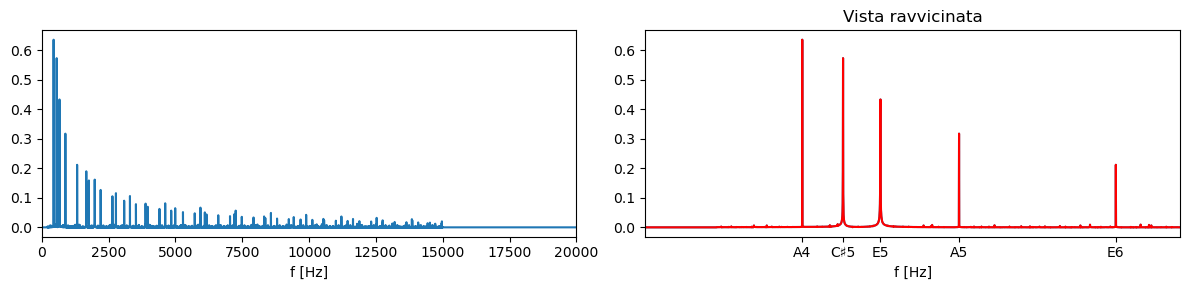

In [6]:
#Tagliamo sotto i 15000Hz e sopra i 200Hz
ftfilt = chord_audio_transf.copy()
indici = np.abs(chord_freq) > 15000
indice2 = np.abs(chord_freq) < 200
ftfilt[indici] = 0
ftfilt[indice2] = 0


#Stampa del grafico per i confronti
fig, (pl1, pl2) = plt.subplots(1, 2, figsize=(12, 3))

#Veidiamolo da vicino
pl1.plot(chord_freq, np.abs(ftfilt))
pl1.set_xlim(0, 20000)
pl1.set_xlabel('f [Hz]')

#Vediamo i picchi
peaks, _ = find_peaks(np.abs(ftfilt), height=0.2)
#Tengo solo i picchi positivi
peaks = peaks[chord_freq[peaks] > 0]
pl2.plot(chord_freq, np.abs(ftfilt))

pl2.set_title('Vista ravvicinata')
pl2.plot(chord_freq, np.abs(ftfilt), color='red')
pl2.set_xlabel('f [Hz]')
pl2.set_xlim(0, 1500)
pl2.set_xticks(chord_freq[peaks], labels=librosa.hz_to_note(chord_freq[peaks]))

fig.tight_layout()

E' evidente l'assenza del picco a 110Hz, corrispondente alla nota di basso dell'accordo, ovvero A1

<h2><b>Analisi di un "vero" sintetizzatore</b></h2>

<img src="https://drive.google.com/uc?export=view&id=17ON2PrOXId72XwrJq3SP6a2uqi7nGhI9" width="700" height="300">

Usando Ableton Live, una digital audio workstation, ho suonato lo stesso accordo con un emulatore di sintetizzatore per poi applicarci degli effetti di base

In [7]:
#importiamo un accordo da un sintettizatore
sample_rate, juno = scipy.io.wavfile.read('juno_A.wav')
juno = juno[:,0]
juno = juno/np.max(juno)
IPython.display.Audio(juno, rate=sample_rate)


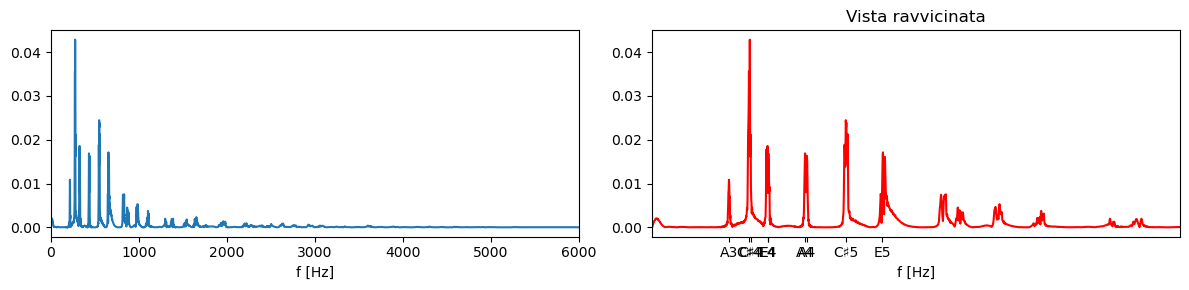

In [9]:
#Applichiamo una trasformata di Fourier
juno_freq = np.fft.fftfreq(len(juno), 1/sample_rate)
juno_freq = np.fft.fftshift(juno_freq)
juno_transf = np.fft.fft(juno/len(juno))
juno_transf = np.fft.fftshift(juno_transf)


#Stampa del grafico per i confronti
fig, (pl1, pl2) = plt.subplots(1, 2, figsize=(12, 3))
#Visualizziamo lo spettro
pl1.plot(juno_freq, np.abs(juno_transf))
pl1.set_xlabel('f [Hz]')
pl2.set_title('Sintetizzatore senza filtri')
pl1.set_xlim(0, 6000)

#Vediamolo da vicino
#Troviamo i picchi
peaks, _ = find_peaks(juno_transf, height=0.008)
#Tengo solo i picchi positivi
peaks = peaks[juno_freq[peaks] > 0]
#Teniamolo soli i picchi fino a 1500Hz
peaks = peaks[juno_freq[peaks] < 1500]


pl2.plot(juno_freq, np.abs(juno_transf), color = 'red')
pl2.set_xlabel('f [Hz]')
pl2.set_title('Vista ravvicinata')
pl2.set_xlim(0, 1500)
pl2.set_xticks(juno_freq[peaks], labels=librosa.hz_to_note(juno_freq[peaks]))

fig.tight_layout()

Le apparenti imprecisioni del grafico di destra sono dovute all'imprecisione del sintetizzatore utilizzato: avendo diverse note uguali ma allo stesso tempo leggermente "stonate", ha rilevato più picchi vicini

Possiamo qiundi notare come il suono risulti meno preciso rispetto a quello da noi generato precedentemente, questo perchè i sintetizzatori cercano di generare un suono più musicale e tendono a "sporcare" il segnale per rendere il risultato più naturale

<h2><b>Analisi del sound processing "in studio"</b></h2>

Ora applichiamo degli effetti digitali inclusi in una digital audio workstation.<br>
Guarderemo in dettaglio: <b>compressore</b>, <b>riverbero</b> e <b>chorus</b>
<table><tr>
    <td><img src="https://drive.google.com/uc?export=view&id=1m7Z1qSWdk4sPGMpt0pqbxf6-Uo-tNTyH" width="370" height="200"></td>
    <td><img src="https://drive.google.com/uc?export=view&id=1mIcyVHfvIEJlPprkDI0HEP36ollop-hc" width="250" height="200"></td>
    <td><img src="https://drive.google.com/uc?export=view&id=1_D-8dngDgGSBiBIsCqcoO3MG-jSLUrzn" width="500" height="200"></td>
    </tr></table>
Screenshot effettivi dei filtri applicati

<h3><b>Compressore</b></h3> 
<un>
Cosa ci aspettiamo?
<li>Un intervento sulla dinamica del suono, avvicinando i picchi e i livelli più bassi del campione</li>
</un>

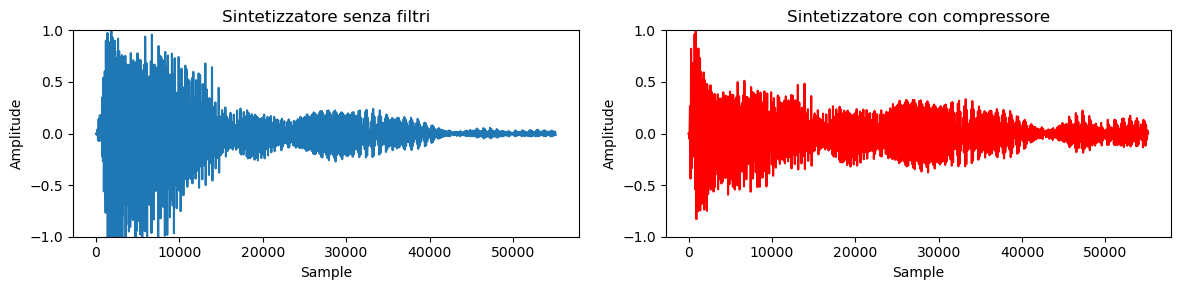

In [10]:
#importiamo il suono dopo aver applicato un compressore
sample_rate, juno_comp = scipy.io.wavfile.read('juno_compresso.wav')
juno_comp = juno_comp[:,0]
juno_comp = juno_comp/np.max(juno_comp)
IPython.display.Audio(juno_comp, rate=sample_rate)

#Osserviamo la differenza tra i due suoni
#Dinamica perchè il compressore agisce su di essa
fig, (pl1, pl2) = plt.subplots(1, 2, figsize=(12, 3))
pl1.plot(juno)
pl1.set_xlabel('Sample')
pl1.set_ylabel('Amplitude')
pl1.set_ylim(-1, 1)
pl1.set_title('Sintetizzatore senza filtri')

pl2.plot(juno_comp, color='red')
pl2.set_xlabel('Sample')
pl2.set_ylabel('Amplitude')
pl2.set_ylim(-1, 1)
pl2.set_title('Sintetizzatore con compressore')

fig.tight_layout()

<h4><b>Osservazioni:</b></h4>
<ul>
<li>Il suono risulta effettivamente essere più compatto, dimunuendo la distanza tra i punti più bassi e i picchi del campione
<li>Abbiamo comunque un picco iniziale, questo perchè il valore <i>"Attack"</i> permette di decidere con quanta prontezza il compressore agisce
<li>L'accordo risultà naturale ma con una "coda" o sustain più accentuata
<li>Se non avessi selezionato l'opzione <i>"Makeup"</i>, il suono sarebbe risultato più basso. Questa opzione permette di recuperare l'intensità persa durante la compressione
<li>Non serve osservare la trasformata di Fourier perchè abbiamo una modulazione tonale trascurabile
<br>
</ul>
<b>Il compressore permette quindi di aumentare il dettaglio del campione, portando in primo piano anche suoni più lievi che altrimenti potrebbero venire persi</b>


<h3><b>Chorus</b></h3> 
<un>
Cosa ci aspettiamo?
<li>Modulazione del campione e con ritardi leggere per simulare una molteplicità di suoni simili, proprio come un coro </li>
</un>

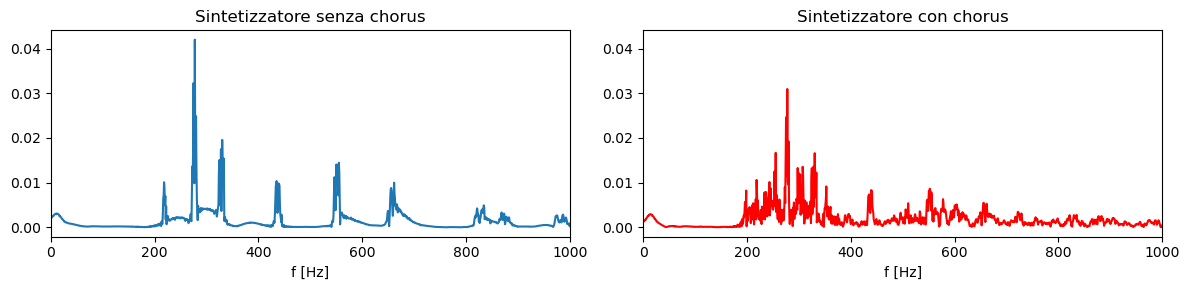

In [11]:
#Applichiamo effetto chorus
sample_rate, juno_chorus = scipy.io.wavfile.read('juno_chorus.wav')
juno_chorus = juno_chorus[:,0]
juno_chorus = juno_chorus/np.max(juno_chorus)
#IPython.display.Audio(juno_chorus, rate=sample_rate)

#Osserviamo la differenza tra i due suoni
#Fourier perchè il chorus agisce su distosione tonale e delay
juno_chorus_transf = np.fft.fft(juno_chorus/len(juno_chorus))
juno_chorus_transf = np.fft.fftshift(juno_chorus_transf)
juno_freq = np.fft.fftfreq(len(juno_chorus), 1/sample_rate)
juno_freq = np.fft.fftshift(juno_freq)

juno_comp_transf = np.fft.fft(juno_comp/len(juno_comp))
juno_comp_transf = np.fft.fftshift(juno_comp_transf)

fig, (pl1, pl2) = plt.subplots(1, 2, figsize=(12, 3))
pl1.plot(juno_freq, np.abs(juno_comp_transf))
pl1.set_xlabel('f [Hz]')
pl1.set_title('Sintetizzatore senza chorus')
pl1.set_xlim(0, 1000)
pl1.sharey(pl2)

pl2.plot(juno_freq, np.abs(juno_chorus_transf), color='red')
pl2.set_xlabel('f [Hz]')
pl2.set_title('Sintetizzatore con chorus')
pl2.set_xlim(0, 1000)

fig.tight_layout()



<h4><b>Osservazioni:</b></h4>
<ul>
<li>La trasformata di Fourier enfatizza l'evidente modulazione dal punto di vista tonale, che arricchisce il suono
<li>I picchi principali rimangono gli stessi, infatti l'effetto non snatura completamente il suono, ma crea la cosiddetta <i>"texture"</i>
</ul>
<b>Il chorus permette di modificare più pesantemente il suono, aumentando quindi la quantità effettiva di informazione contenuta nel segnale</b>

<h3><b>Riverbero</b></h3> 
<un>
Cosa ci aspettiamo?
<li>Un altro intervento di modulazione del segnale audio, genernado ritardi e feedback per simulare l'effetto di rifelsso del suono in un ambiente reale </li>
</un>

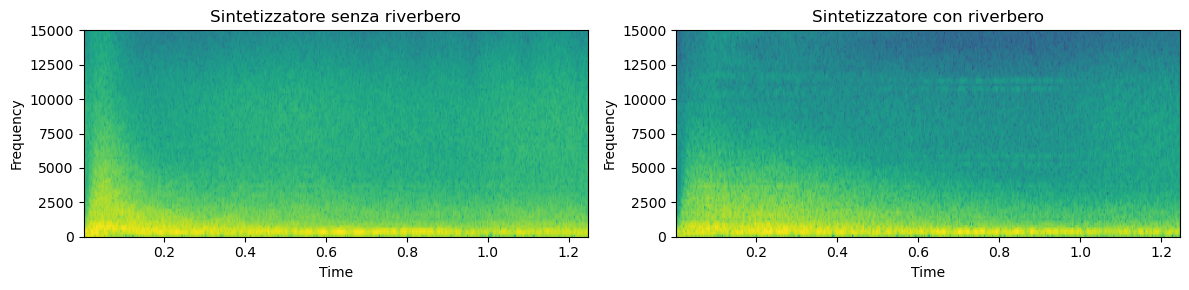

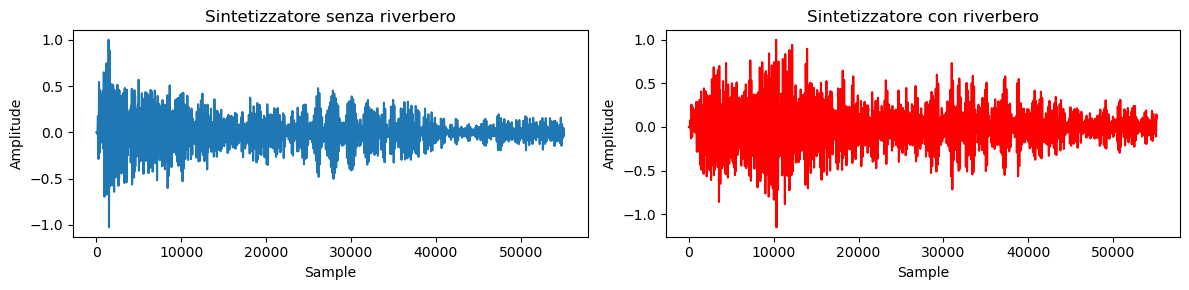

In [12]:
sample_rate, juno_reverb = scipy.io.wavfile.read('juno_reverb.wav')
juno_reverb = juno_reverb[:,0]
juno_reverb = juno_reverb/np.max(juno_reverb)
#IPython.display.Audio(juno_reverb, rate=sample_rate)

#Osserviamo la differenza tra i due suoni su spettrogramma
#Spettrogramma perchè il riverbero agisce nel tempo

fig, (pl1, pl2) = plt.subplots(1, 2, figsize=(12, 3))

# Plot spectrogram for the original sound
pl1.specgram(juno_chorus, Fs=sample_rate)
pl1.set_xlabel('Time')
pl1.set_ylim(0, 15000)
pl1.set_ylabel('Frequency')
pl1.set_title('Sintetizzatore senza riverbero')

# Plot spectrogram for the sound with reverb
pl2.specgram(juno_reverb, Fs=sample_rate)
pl2.set_xlabel('Time')
pl2.set_ylim(0, 15000)
pl2.set_ylabel('Frequency')
pl2.set_title('Sintetizzatore con riverbero')

fig.tight_layout()

#Osserviamo la dinamica del suono con e senza riverbero
fig, (pl1, pl2) = plt.subplots(1, 2, figsize=(12, 3))
pl1.plot(juno_chorus)
pl1.set_xlabel('Sample')
pl1.set_ylabel('Amplitude')
pl1.set_title('Sintetizzatore senza riverbero')

pl2.plot(juno_reverb, color='red')
pl2.set_xlabel('Sample')
pl2.set_ylabel('Amplitude')
pl2.set_title('Sintetizzatore con riverbero')

fig.tight_layout()

<h4><b>Osservazioni</b></h4>
<ul>
<li>Osserviamo come il picco del segnale si presenti dopo rispetto al segnale senza riverbero, questo perchè stiamo osservando quasi esclusivamente il segnale di riflesso generato dall'effetto (l'impostazione <i>Dry/Wet</i> è impostata al 91%)
<li>Lo spettrogramma evidenza una carenza di segnale oltre i 50kHz, questo perchè l'effetto presenta un filtro che taglia il suono oltre questa soglia, per evitare di dare troppo spazio al segnalr
<li>Dallo spettrogramma si può inoltre notare come il picco iniziale venga "sgranato". Questo perchè il picco durerà più a lungo e sarà quindi meno intenso

<h1><b>Conclusioni</b></h1>
L'idea iniziale di creare un sintetizzatore completo DIY avrebbe significato anche implementare i filtri che abbiamo visto ma avrebbero richiesto un progetto ciascuno. Ho ritenuto altrettanto interessante dare un'infarinatura di base, in quanto <i>sound designer da cameretta</i> sul processo dietro alla sintesi dei suoni, dalla loro nascita ad alcuni semplici effetti ai quali vengono sottoposti nel processo di sound design.
Con questo progetto spero di aver mostrato all'ascoltatore il processo per il quale i segnali audio passano, prima di trovare spazio nelle canzoni che ascoltiamo tutti i giorni